In [1]:
# Pacotes 
import matplotlib.pyplot as plt
import numpy as np
import scipy  as sp
from LightPipes import *


In [2]:
# Fenda:
n     = 2**8
lambd = 780*nm 
dx    = 5*um 

class grid:
  pass
grid.N  = n;   
grid.dx = dx                               
grid.x  = np.arange(-grid.N/2,grid.N/2,1)*grid.dx
[grid.xx,grid.yy] = np.meshgrid(grid.x,grid.x);  

In [3]:
# Campo 
# Definindo o campo 
def caiLG(L,P,w0,lamb,xx,yy):
  z_R  = np.pi*w0**2/lamb  
  r    = np.sqrt(xx**2+yy**2)                                                 
  C    = np.sqrt(2*np.math.factorial(P)/(np.pi*np.math.factorial(P+abs(L))))
  PL   = sp.special.assoc_laguerre(2*r**2/w0**2,P,abs(L))

  Fase = np.exp(- 1j*L*np.arctan2(yy,xx) )
  LG   = C*1/w0*(r*np.sqrt(2)/w0)**abs(L)*PL*np.exp( -r**2/w0**2)*Fase

  return LG
### Função da Suavização #########################
def SUAVE(media, linha):
  novalista = []
  for i in range(media ,n,1):
    novalista.append( sum(slitSS[linha,i-media:i])/media)
  return np.array(novalista)

def MM(suavizar,linha):
  curva = SUAVE(suavizar,linha)
  maxi2 = curva.max()
  posiçao2 = 0
  for i in curva:
    if i == maxi2:
      break 
    posiçao2 +=1 

  #### Encontrar o valor mínimo local a Direita parti do maximo global
  mini = 0
  Vimax = curva[posiçao2:n]
  for i in range(len(Vimax)):
    if i == len(Vimax)-1:
      break
    if Vimax[i] > Vimax[i+1]:
      mini = Vimax[i+1]
    elif Vimax[i] < Vimax[i+1]:
      mini = Vimax[i]
      break   
  # Vamos encontrar o posição no qual temos mínimo
  PMin = 0 
  for i in Vimax:
    if i == mini:
      break 
    PMin += 1  
  posiçaomin = posiçao2 + PMin -1
#######################################################################
#### Encontrar o valor mínimo local a ESQUERDA a parti do maximo lobal
  miniE = 0
  xamiV = curva[0:posiçao2]
#########################################################
  for i in range(len(xamiV)):
    i += 1
    if i == len(xamiV)-1:
      break
    if xamiV[-i] > xamiV[-i-1]:
      miniE = xamiV[-i-1]
    elif xamiV[-i] < xamiV[-i-1]:
      miniE = xamiV[-i]
      break   
  # Vamos encontrar o posição no qual temos mínimo
  PMinE = 0 
  for i in range(len(xamiV)):
    i+=1
    if xamiV[-i] == miniE: 
      break 
    PMinE += 1  
  posiçaominE = posiçao2 - PMinE

  if miniE > mini:
    posiçaomin = posiçaominE
    mini       = miniE
  # [0] = Valor max,[1] = Posição max ,[2] = Valor Min,[3] = Posição Min
  return maxi2, posiçao2, mini, posiçaomin  #,miniE, posiçaominE  

def campo_final(T,lambd,delta,sigma,n,dx,weight_cutoff):
    # Parâmetros do feixe TGSM
    k     = 2*np.pi/lambd
    a     = 1/(4*sigma**2) # [L]^-2
    b     = 1/(2*delta**2) # [L]^-2
    mu    = T/(k*delta**2)

    t      = np.sqrt(abs((b+k*mu/2)/(b-k*mu/2))) # # no unit, always positive
    auxNum = np.sqrt(4*a**2+8*a*b+(k*mu)**2)     # [L]^-2, always positive
    w      = np.sqrt(2/auxNum)                   # [L], always positive
    chi    = ((2*a+2*b-auxNum)/(2*a+2*b+auxNum)) # no unit, always positive??
    
    # Determinando os modos que precisam entrar na decomposição
    p_par     = np.arange(0,50)
    l_par     = np.arange(-100,100)
    lp_par    = np.zeros((l_par.size*p_par.size,2),dtype=int)
    bla       = np.zeros((l_par.size*p_par.size))
    weight_00 = (np.pi/2)*w**2*(1-chi)
    contador  = 0
    for i in p_par:
        for j in l_par:
            weight = np.pi/2*w**2*(1-chi)*t**l_par[j]*abs(chi)**(abs(l_par[j])/2+p_par[i])
            if weight/weight_00 >= weight_cutoff:
                lp_par[contador,:] = [l_par[j], p_par[i]]
                bla[contador]      = weight
                contador = contador +1
    lp_par = lp_par[:contador,:]
    bla    = bla[:contador]
    
    # Gerando os campos para a soma incoerente 
    x  = np.arange(-n/2, n/2,1)*dx
    xx,yy = np.meshgrid(x,x)
    S =  np.exp(1j*np.zeros((n,n,lp_par.shape[0])))

    for i in range(lp_par.shape[0]):
        weight = np.pi/2*w**2*(1-chi)*t**lp_par[i,0]*chi**(abs(lp_par[i,0])/2+lp_par[i,1])
        # usando a função do artigo para os modos
        LG = caiLG(lp_par[i,0],lp_par[i,1],w,lambd,xx,yy)
        S[:,:,i] = np.sqrt(weight)*LG
    
    return S,lp_par  
  
def slit(d0,a0,xx):
  return (np.ones_like(xx)*(abs(xx+(d0/2))<=a0/2) + np.ones_like(xx)*(abs(xx-(d0/2))<=a0/2))

def Interferencia(F,S,Islits,lp_par,z):
    sSS = [0]
    FF  = F.copy(F)
    for i in range(lp_par.shape[0]):
        FF.field = S[:,:,i]*Islits
        FF1 = Forvard(z,FF)
        sSS += Intensity(FF1)
    return sSS     
def Visivilidade(q,n,media):
    Vis = []
    qq = 0
    for j in range(n//2-media,n//2+media ):
        Vis.append(  ( MM(q,j)[0]-MM(q,j)[2])/(MM(q,j)[0]+MM(q,j)[2]) ) 
        qq+=1  
    return sum(Vis)/qq
     

# Modo Coerente:

### test:

Número de modos: 11


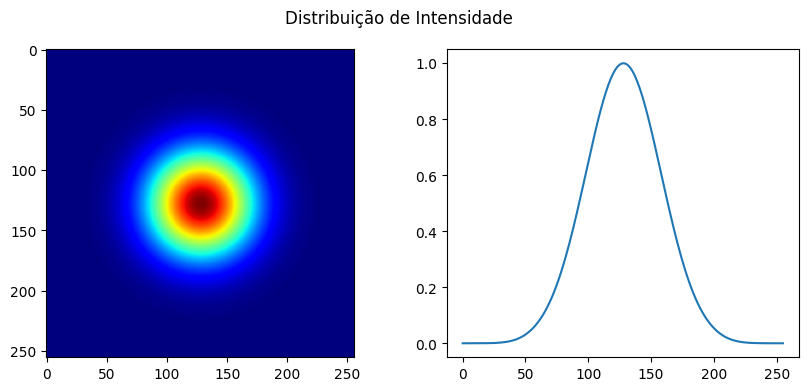

In [4]:
S = campo_final(0.999,lambd,.15*mm,.15*mm,n,dx,weight_cutoff=0.015)
print("Número de modos:",len(S[1]))
# show the total image of the incoherent sum
img = np.sum(abs(S[0])**2,2)
img = img/img.max()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
fig.suptitle('Distribuição de Intensidade')

ax1.imshow(img,cmap="jet")
ax2.plot(img[:,int(n/2)])
plt.show()

### Com poucos modos:

In [5]:
S1,lp_par1 = campo_final(0.999,lambd,0.15*mm,0.15*mm,n,dx,0.015)
S2,lp_par2 = campo_final(0.999,lambd,0.1*mm ,0.15*mm,n,dx,0.015)
S3,lp_par3 = campo_final(0.999,lambd,0.05*mm,0.15*mm,n,dx,0.015)

In [ ]:
z  = 0.85*cm
q  = 2
a0 = (0.05/3)*mm; 
F  = Begin(abs(grid.x[0])*2,lambd,n-1) 
media = 30
data  = []

################################################
data_i =[]
for ii in range(25):
  # make slit
  Islits = slit((ii/100)*mm ,a0,grid.xx)
  slitSS = Interferencia(F,S1,Islits,lp_par1,z)
  data_i.append(Visivilidade(q,n,media))
data.append(np.array(data_i))
################################################

data_i = []
for ii in range(20):
  # make slit
  Islits = slit((ii/100)*mm ,a0,grid.xx)
  slitSS = Interferencia(F,S2,Islits,lp_par2,z)
  data_i.append(Visivilidade(q,n,media))
data.append(np.array(data_i))
################################################

data_i = []
for ii in range(15):
  # make slit
  Islits = slit((ii/100)*mm ,a0,grid.xx)
  slitSS = Interferencia(F,S3,Islits,lp_par3,z)
  data_i.append(Visivilidade(q,n,media))
data.append(np.array(data_i))
################################################

In [ ]:
a = 0
plt.plot(np.arange(a,25),data[0],'k.')
plt.plot(np.arange(a,25),np.ones(len(data[0]))*0.37,label=f'0.37')

plt.plot(np.arange(a,20),data[1],'r.')
#plt.plot(np.arange(a,25),np.ones(len(data[0]))*data[1][0]*0.37,'r--',label=f'$\delta:$=0.1mm')

plt.plot(np.arange(a,15),data[2],'b.')
#plt.plot( np.cos(-np.linspace(0,1,25)*(3.3)+0.05)**2,'--')
#plt.plot(np.arange(a,25),np.ones(len(data[0]))*data[2][0]*0.37,'b--',label=f'$\delta:$=0.05mm')
plt.title("Modo coerente")
plt.legend()
plt.ylabel("Visibilidade")
plt.xlabel("Distância entre as fendas(mm/100)")
plt.xticks(np.arange(a,25))
plt.show()

In [ ]:
print( "d :",np.round((0.15)*np.sqrt(2),2),  "ERRO_d :",np.round(0.01,2))
print( "d :",np.round((0.1)*np.sqrt(2),2))
print( "d :",np.round((0.05)*np.sqrt(2),2))

Erro da visibilidade

In [ ]:
print( "d :",np.round((0.15)*np.sqrt(2),2),  "ERRO_d :",np.round(0.01,2))
print( "d :",np.round((0.1)*np.sqrt(2),2))
print( "d :",np.round((0.05)*np.sqrt(2),2))

### Com 350 modos

S1,lp_par1  =  campo_final(0.999,lambd,delta=0.15*mm,sigma=0.15*mm,n= 2**8,dx = 5*um ,weight_cutoff=5e-20)
print(len(lp_par1))
S2,lp_par2 =  campo_final(0.999,lambd,delta=.1*mm ,sigma=0.15*mm,n= 2**8,dx = 5*um ,weight_cutoff=3e-15)
print(len(lp_par2))
S3,lp_par3 =  campo_final(0.999,lambd,delta=.05*mm,sigma=0.15*mm,n= 2**8,dx = 5*um ,weight_cutoff=1e-11)
print(len(lp_par3))

z  = 0.85*cm
q  = 2
a0 = (0.05/3)*mm; 
F  = Begin(abs(grid.x[0])*2,lambd,n-1) 
media = 30
data  = []

################################################
data_i =[]
for ii in range(25):
  # make slit
  Islits = slit((ii/100)*mm ,a0,grid.xx)
  slitSS = Interferencia(F,S1,Islits,lp_par1,z)
  data_i.append(Visivilidade(q,n,media))
data.append(np.array(data_i))
################################################

data_i = []
for ii in range(20):
  # make slit
  Islits = slit((ii/100)*mm ,a0,grid.xx)
  slitSS = Interferencia(F,S2,Islits,lp_par2,z)
  data_i.append(Visivilidade(q,n,media))
data.append(np.array(data_i))
################################################

data_i = []
for ii in range(15):
  # make slit
  Islits = slit((ii/100)*mm ,a0,grid.xx)
  slitSS = Interferencia(F,S3,Islits,lp_par3,z)
  data_i.append(Visivilidade(q,n,media))
data.append(np.array(data_i))
################################################


